# FROM SENTIMENT ANALYSIS TO EMOTION RECOGNITION

Notebook 4 -> Emotion Recognition Good Data

In [ ]:
# Mount Drive
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/DeepLearning_2020/Final_Project/Data/'
data_path = '/content/drive/My Drive/DeepLearning_2020/Final_Project/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2020/Final_Project/Results/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
 0_test_geri.ckpt      sentiment_tweets.csv   train.txt
 5_test_geri.ckpt     'Task 1'		      twitter-2016test-A.txt
 Emotion_Dataset.txt   test.txt		      twitter-2016train-A.txt
 emotion_tweets.pkl    text_emotion.csv


Necessary imports

In [ ]:
import csv
import numpy as np
from collections import Counter 
from string import punctuation
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import pickle

Load the data

In [ ]:
file = 'emotion_tweets.pkl'

def read_file(file):
    tweets = [] 
    labels = []
    with open(data_path + file, 'rb') as f:
        dataframe = pickle.load(f)
    tweets = dataframe['text'].tolist()
    labels = dataframe['emotions'].tolist()
    return tweets, labels

tweets, labels = read_file(file)
num_labels = len(set(labels))

Display the distribution of the data

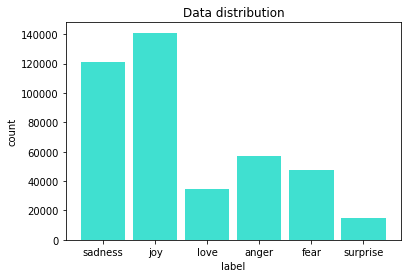

In [ ]:
plt.hist(labels, bins = range(num_labels + 1), color = 'turquoise', rwidth = 0.85, align = 'left')
plt.title('Data distribution')
plt.xlabel('label')
plt.ylabel('count')
plt.savefig(results_path + 'ER_GoodData_Dist.png')
plt.show()

Preprocess tweets

In [ ]:
# Remove Punctuation and get all the tweets from review dataset
def remove_punctutation(tweets): 
    all_tweets = []
    for text in tweets:
        text = text.lower()
        text = "".join([ch for ch in text if ch not in punctuation])
        all_tweets.append(text)
    all_text = " ".join(all_tweets)
    all_words = all_text.split(' ')
    
    # Remove web address and user handles
    new_tweets = []
    for tweet in all_tweets:
      #tweet = tweet.split()
      new_text = []
      for word in tweet.split(' '):
        if(len(word) > 0):
          if (word[0] != '@') & ('http' not in word) & (~word.isdigit()):
              new_text.append(word)
              
      new_tweets.append(new_text)
    return all_words, new_tweets

# Count all the words and sort it based on counts
def count_sort(all_words):
    count_words = Counter(all_words)
    total_words = len(all_words)
    sorted_words = count_words.most_common(total_words)
    return sorted_words

# Create a dictionary to convert words to Integers based on the number of occurrence of the word
def to_dictionary(sorted_words):
    vocab_to_int = {w:i+1 for i,(w,c) in enumerate(sorted_words)}
    return vocab_to_int

# Encode tweets in to list of Integer by using above dictionary
def encode_tweets(all_tweets, vocab_to_int):
    encoded_tweets = list()
    for tweet in all_tweets:
        encoded_tweet = list()
        
        for word in tweet:
            if word not in vocab_to_int.keys():
            #if word is not available in vocab_to_int put 0 in that place
                encoded_tweet.append(0)
            else:
                encoded_tweet.append(vocab_to_int[word])
        encoded_tweets.append(encoded_tweet)

    return encoded_tweets

# Make all the encoded_review of the same length
def get_features(encoded_tweets):
    sequence_length = 250
    features = np.zeros((len(encoded_tweets), sequence_length), dtype = int)
    for i, tweet in enumerate(encoded_tweets):
        tweet_len = len(tweet)
        if (tweet_len <= sequence_length):
            zeros = list(np.zeros(sequence_length - tweet_len))
            new = zeros + tweet
        else:
            new = tweet[:sequence_length]

        features[i, :] = np.array(new)

    return features

def get_labels(labels):
    labels = [0 if label.strip() == 'sadness' else 1 if label.strip() == 'joy' else 2 if label.strip() == 'love' 
              else 3 if label.strip() == 'anger' else 4 if label.strip() == 'fear' else 5 for label in labels]
    return labels


# Perform all pre-processing of the data
def preprocess_data(tweets, labels):
    all_words, all_tweets = remove_punctutation(tweets)
    sorted_words = count_sort(all_words)
    vocab_to_int = to_dictionary(sorted_words)
    encoded_tweets = encode_tweets(all_tweets, vocab_to_int)
    features = get_features(encoded_tweets)
    labels = get_labels(labels)
    return features, labels, vocab_to_int

text, labels, vocab_to_int = preprocess_data(tweets, labels)

Split the dataset into training and testing


*   Training -> 90 %
*   Testing -> 10 %



In [ ]:
# split data into training and test data (features and labels)
split_frac = 0.9

split_idx = int(len(labels)*split_frac)
features_train, features_test = text[:split_idx], text[split_idx:]
labels_train, labels_test = labels[:split_idx], labels[split_idx:]

# print out the shapes of your resultant feature data
print("Feature Shapes:")
print("Train set: {}".format(features_train.shape), 
      "\nTest set: {}".format(features_test.shape))

Feature Shapes:
Train set: (375128, 250) 
Test set: (41681, 250)


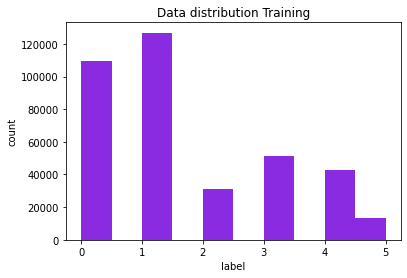

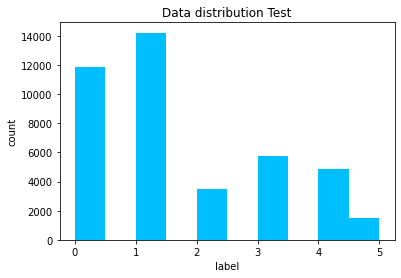

In [ ]:
plt.hist(labels_train, color = 'blueviolet')
plt.title('Data distribution Training')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

plt.hist(labels_test, color = 'deepskyblue')
plt.title('Data distribution Test')
plt.xlabel('label')
plt.ylabel('count')
plt.show()

Transform the data into tensors and the corresponding data loader 

In [ ]:
# Create Tensor Dataset
train_data = TensorDataset(torch.LongTensor(features_train), torch.LongTensor(labels_train))
test_data = TensorDataset(torch.LongTensor(features_test), torch.LongTensor(labels_test))

# Create data loader
batch_size = 128
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True, drop_last = True)

## Network 1

Define the architecture

In [ ]:
class EmotionLSTM1(nn.Module):
    """
    The RNN model that will be used to perform Emotion Recognition.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first = True)
        
        #dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        #Linear and sigmoid layer
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, output_size)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size()*3
        
        #Embadding and LSTM output
        embedd = self.embedding(x)
        lstm_out, hidden = self.lstm(embedd, hidden)
        
        #stack up the lstm output
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)

        sm_out = self.softmax(out)
        
        B = torch.Size([batch_size[0], batch_size[1], output_size])
        sm_out = sm_out.view(B, -1)
        sm_out = sm_out[:, -1]

        return sm_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

Create the network

In [ ]:
# Model hyperparameters
vocab_size = len(vocab_to_int) + 1 
output_size = num_labels
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = EmotionLSTM1(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.2)
print('Network architecture')
print(net)

Network architecture
EmotionLSTM1(
  (embedding): Embedding(75303, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


### Train the network

Epoch: 1/5... Step: 0/2930... Loss: 1.803848...
Epoch: 1/5... Step: 100/2930... Loss: 1.689819...
Epoch: 1/5... Step: 200/2930... Loss: 1.669176...
Epoch: 1/5... Step: 300/2930... Loss: 1.701074...
Epoch: 1/5... Step: 400/2930... Loss: 1.657873...
Epoch: 1/5... Step: 500/2930... Loss: 1.665432...
Epoch: 1/5... Step: 600/2930... Loss: 1.632388...
Epoch: 1/5... Step: 700/2930... Loss: 1.561175...
Epoch: 1/5... Step: 800/2930... Loss: 1.562918...
Epoch: 1/5... Step: 900/2930... Loss: 1.695796...
Epoch: 1/5... Step: 1000/2930... Loss: 1.691966...
Epoch: 1/5... Step: 1100/2930... Loss: 1.746699...
Epoch: 1/5... Step: 1200/2930... Loss: 1.731088...
Epoch: 1/5... Step: 1300/2930... Loss: 1.840464...
Epoch: 1/5... Step: 1400/2930... Loss: 1.801400...
Epoch: 1/5... Step: 1500/2930... Loss: 1.715457...
Epoch: 1/5... Step: 1600/2930... Loss: 1.723286...
Epoch: 1/5... Step: 1700/2930... Loss: 1.777962...
Epoch: 1/5... Step: 1800/2930... Loss: 1.684234...
Epoch: 1/5... Step: 1900/2930... Loss: 1.74

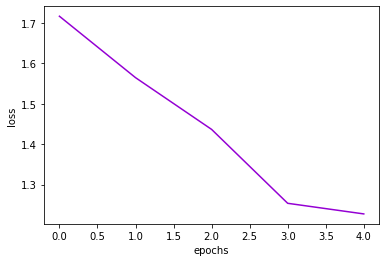

In [ ]:
model_name = '_ER_GoodData_Net1.ckpt'

# loss and optimization functions
criterion = nn.CrossEntropyLoss() 

learning_rate = .1
momentum = .9
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# training params
epochs = 5 
clip = 5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

losses_list = []

net.train()

# initialize hidden state
h = net.init_hidden(batch_size)

# train for some number of epochs
for e in range(epochs):
    loss_avg = 0
    nBatches = 0
    
    # batch loop
    total_step = len(train_loader)

    for i, (inputs, labels) in enumerate(train_loader):
        
        if(train_on_gpu):
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        loss_avg += loss.cpu().item()
        nBatches += 1

        if i % 100 == 0:
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}/{}...".format(i, total_step),
                  "Loss: {:.6f}...".format(loss.item()))
    losses_list.append(loss_avg / nBatches)

    if((e + 1) % 5 == 0 and e != 0):
        plt.plot(losses_list, color = 'darkviolet')
        plt.savefig(results_path + str(e) + '_ER_GoodData_Loss_Net1.png')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        torch.save(net.state_dict(), results_path + str(e) + model_name)

### Test the network

In [ ]:
test_losses = [] # track loss
num_correct = 0
# init hidden state
h = net.init_hidden(batch_size)

y_true = []
y_pred = []

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    y_true.append(labels.numpy())
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.long())
    test_losses.append(test_loss.item())
    
    #print(output)
    pred = output.argmax(1) 
    y_pred.append(pred.cpu().numpy())
    #print(pred)

    # compare predictions to true label
    correct_tensor = pred.eq(labels.long().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 1.217
Test accuracy: 0.824


Display the confusion matrix

Confusion matrix:
 [[11197   345     0   135   172     0]
 [  366 13623     0   111   100     0]
 [  162  3259     0    59    35     0]
 [  207   226     0  5142   171     0]
 [  104   223     0    97  4397     0]
 [   57   985     0    57   370     0]]


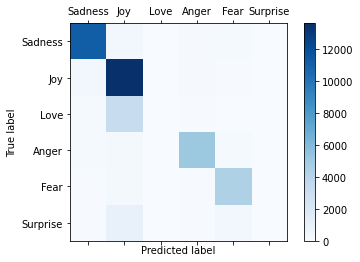

In [ ]:
Y_True = np.concatenate(y_true, axis = 0)
Y_Pred = np.concatenate(y_pred, axis = 0)

conf_mat = confusion_matrix(y_true = Y_True, y_pred = Y_Pred)
print('Confusion matrix:\n', conf_mat)

labels_conf = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap = plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_conf)
ax.set_yticklabels([''] + labels_conf)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig(results_path + 'ER_GoodData_ConfusionMatrix_Net1.png')
plt.show()

## Network 2

Define the architecture

In [ ]:
class EmotionLSTM2(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.5):    
        """
        Initialize the model by setting up the layers
        """
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #Embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first = True)
        
        #dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        #Linear and sigmoid layer
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size()*3
        
        #Embadding and LSTM output
        embedd = self.embedding(x)
        lstm_out, hidden = self.lstm(embedd, hidden)
        
        #stack up the lstm output
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        #dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc(out)

        sm_out = self.softmax(out)
        
        B = torch.Size([batch_size[0], batch_size[1], output_size])
        sm_out = sm_out.view(B, -1)
        sm_out = sm_out[:, -1]
        
        return sm_out, hidden
    
    def init_hidden(self, batch_size):
        """Initialize Hidden STATE"""
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

Create the network

In [ ]:
# Model hyperparameters
vocab_size = len(vocab_to_int) + 1 
output_size = num_labels
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = EmotionLSTM2(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.2)
print('Network architecture')
print(net)

Network architecture
EmotionLSTM2(
  (embedding): Embedding(75303, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)


### Train the network

Epoch: 1/5... Step: 0/2930... Loss: 1.795062...
Epoch: 1/5... Step: 100/2930... Loss: 1.667931...
Epoch: 1/5... Step: 200/2930... Loss: 1.647766...
Epoch: 1/5... Step: 300/2930... Loss: 1.643483...
Epoch: 1/5... Step: 400/2930... Loss: 1.659873...
Epoch: 1/5... Step: 500/2930... Loss: 1.559729...
Epoch: 1/5... Step: 600/2930... Loss: 1.527177...
Epoch: 1/5... Step: 700/2930... Loss: 1.650358...
Epoch: 1/5... Step: 800/2930... Loss: 1.552428...
Epoch: 1/5... Step: 900/2930... Loss: 1.521090...
Epoch: 1/5... Step: 1000/2930... Loss: 1.532808...
Epoch: 1/5... Step: 1100/2930... Loss: 1.454344...
Epoch: 1/5... Step: 1200/2930... Loss: 1.523248...
Epoch: 1/5... Step: 1300/2930... Loss: 1.487066...
Epoch: 1/5... Step: 1400/2930... Loss: 1.472921...
Epoch: 1/5... Step: 1500/2930... Loss: 1.527771...
Epoch: 1/5... Step: 1600/2930... Loss: 1.531283...
Epoch: 1/5... Step: 1700/2930... Loss: 1.479347...
Epoch: 1/5... Step: 1800/2930... Loss: 1.477383...
Epoch: 1/5... Step: 1900/2930... Loss: 1.50

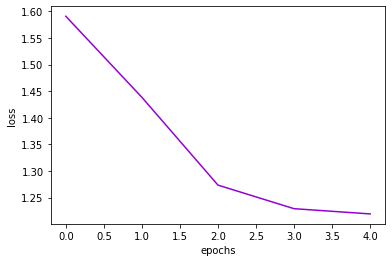

In [ ]:
model_name = '_ER_GoodData_Net2.ckpt'

# loss and optimization functions

criterion = nn.CrossEntropyLoss() 

learning_rate = .1
momentum = .9
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate, momentum = momentum)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# training params
epochs = 5 
clip = 5 # gradient clipping

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

losses_list = []
net.train()

# initialize hidden state
h = net.init_hidden(batch_size)

# train for some number of epochs
for e in range(epochs):
    loss_avg = 0
    nBatches = 0

    # batch loop
    total_step = len(train_loader)
    for i, (inputs, labels) in enumerate(train_loader):
        
        if(train_on_gpu):
            inputs = inputs.cuda()
            labels = labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels)
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        loss_avg += loss.cpu().item()
        nBatches += 1

        if i % 100 == 0:
            print("Epoch: {}/{}...".format(e + 1, epochs),
                  "Step: {}/{}...".format(i, total_step),
                  "Loss: {:.6f}...".format(loss.item()))
    losses_list.append(loss_avg / nBatches)

    if((e + 1) % 5 == 0 and e != 0):
        plt.plot(losses_list, color = 'darkviolet')
        plt.savefig(results_path + str(e) + '_ER_GoodData_Loss_Net2.png')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()
        torch.save(net.state_dict(), results_path + str(e) + model_name)

### Test the network

In [ ]:
test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

y_true = []
y_pred = []

net.eval()

# iterate over test data
for inputs, labels in test_loader:

    y_true.append(labels.numpy())
    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.long())
    test_losses.append(test_loss.item())
    
    pred = output.argmax(1) 
    y_pred.append(pred.cpu().numpy())

    # compare predictions to true label
    correct_tensor = pred.eq(labels.long().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 1.219
Test accuracy: 0.823


Display the confusion matrix

Confusion matrix:
 [[11188   333     0   132   204     0]
 [  349 13642     0   113    94     0]
 [  151  3130     0    77   161     0]
 [  214   402     0  5100    20     0]
 [   85   134     0   227  4379     0]
 [  175   779     0    69   442     0]]


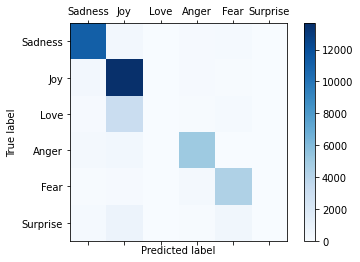

In [ ]:
Y_True = np.concatenate(y_true, axis = 0)
Y_Pred = np.concatenate(y_pred, axis = 0)

conf_mat = confusion_matrix(y_true = Y_True, y_pred = Y_Pred)
print('Confusion matrix:\n', conf_mat)

labels_conf = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap = plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_conf)
ax.set_yticklabels([''] + labels_conf)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig(results_path + 'ER_GoodData_ConfusionMatrix_Net2.png')
plt.show()